# Определение возраста покупателей

Сетевой супермаркет **«Хлеб-Соль»** внедряет систему компьютерного зрения для обработки фотографий покупателей. 

*Фотофиксация* в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая **по фотографии определит приблизительный возраст** человека. 

В нашем распоряжении набор фотографий людей с указанием возраста.

**План выполнения работы:**

1. Проведём исследовательский анализ набора фотографий.
2. Подготовим данные к обучению.
3. Обучим нейронную сеть и рассчитаем её качество.
4. Проанализируем результаты обучения и сделаем выводы.

## Исследовательский анализ данных

В нашем распоряжении одна папка со всеми изображениями (`/final_files`) и *csv*-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

Для начала импортируем библиотеки:

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Загружаем *csv*-файл `labels.csv` (с двумя колонками: `file_name` и `real_age`):

In [2]:
#прочитаем данные из csv-файла labels.csv в датафрейм, 
#который на следующем шаге станет одним из параметров метода 
#ImageDataGenerator: flow_from_dataframe(dataframe, directory, ...)

labels = pd.read_csv('/datasets/faces/labels.csv')

Инициализируем удобный загрузчик `ImageDataGenerator` из библиотеки `Keras`: 

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)

Из фотографий в папках класс `ImageDataGenerator` формирует батчи с изображениями и метками классов.

Чтобы загрузчик извлёк данные из папки, вызовем функцию **`flow_from_dataframe()`**:

In [4]:
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   
                                                   # папка, в которой хранится датасет
                                                   directory='/datasets/faces/final_files/',
                                                   
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   
                                                   # к какому размеру приводить изображения
                                                   target_size=(224, 224),
                                                   
                                                   # размер батча
                                                   batch_size=32,
                                                   
                                                   # в каком виде выдавать метки классов
                                                   class_mode='raw',
                                                   
                                                   # фиксируем генератор случайных чисел (от англ. random seed)
                                                   seed=12345)

Found 7591 validated image filenames.


Выведем **общую информацию** о датафрейме с метками:

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В нашем распоряжении **7591 фотография** и метка с возрастом к ней. Пропущенные значения отсутствуют.

Выведем **первые несколько строк**:

In [6]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Посмотрим характеристику выборки по возрасту:

In [7]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Среднее значение **31,2**, медиана **29**. Стандартное отклонение больше половины среднего значения. Что может говорить о скошенности датафрейма. Максимум - 100 лет, минимум - 1 год.

Ознакомимся с гистограммой значений возраста:

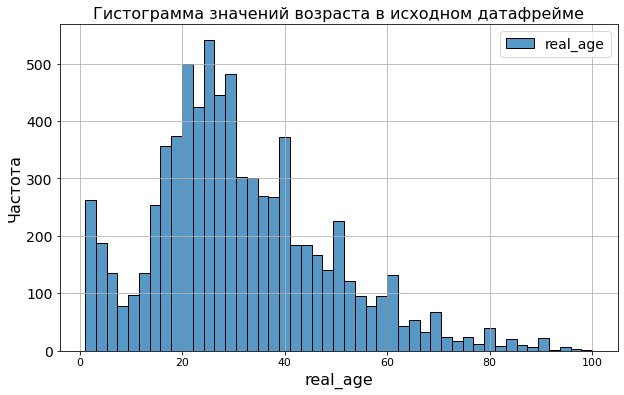

In [8]:
#размер графика
plt.figure(figsize=(10,6))

sns.histplot(labels['real_age'],
             label='real_age')
#название графика
plt.title('Гистограмма значений возраста в исходном датафрейме', fontsize=16 )

#подписи осей
plt.xlabel('real_age', fontsize=16)
plt.ylabel('Частота', fontsize=16)

#задаём размер значений на оси абсцисс и на оси ординат
plt.xticks(fontsize=11)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

#отображение сетки
plt.grid()
plt.show()

Из гистограммы количества фотографий по возрастам мы видим, что датафрейм имеет два пика:
- первый в детском возрасте,
- второй в возрасте около 25-30 лет.
Визуально можно отнести датафрейм к скошенным вправо, так как после пика 25-30 лет начинается более плавное снижение количества фотографий до возраста 100 лет, чем в область детского возраста, где количество фотографий сначала резко снижается, затем увеличивается до второго пика.

Напечатаем на экране 10–15 фотографий из первого батча:

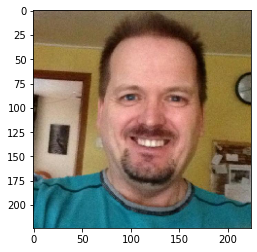

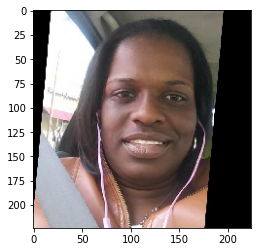

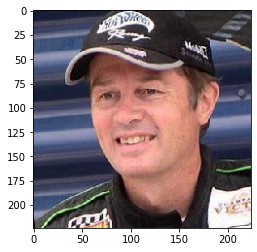

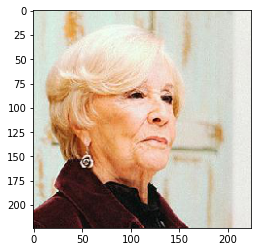

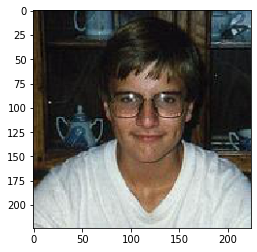

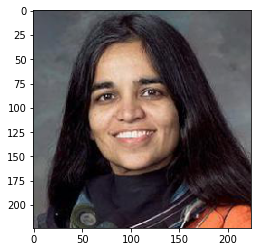

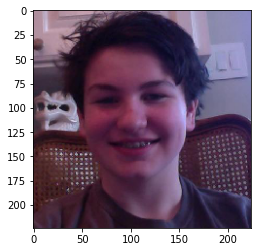

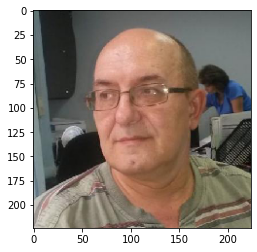

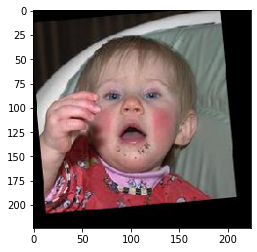

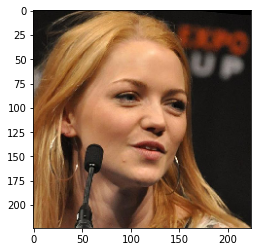

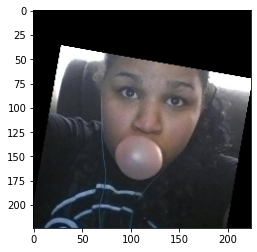

In [9]:
for i in range(0,11):
    plt.figure()
    plt.imshow(train_gen_flow[0][0][i])
    plt.show()

По выведенным 10 изображениям можно утвержать, что датафрейм интересный: и кепка, и очки, и жвачка, и микрофон. Масса факторов, которые могут помешать модели верно определить возраст.

**Дополнительно** выведем ещё **10 фотографий**, но с **возрастом**, чтобы посмотреть насколько сложная задача перед нами стоит.

Для этого сохраним пару *признаки-целевой признак*:

In [10]:
features, target=next(train_gen_flow)

Посмотрим размерность признаков:

In [11]:
features.shape

(32, 224, 224, 3)

Это 1 батч из 32 цветных фотографий.

Посмотрим набор целевого признака для данного батча: 

In [12]:
target

array([23, 32, 49, 32, 38, 25, 16, 23, 34, 24, 90, 41, 41, 44, 23, 20, 47,
       37, 23, 21, 31, 35, 66, 14, 35,  8, 18, 24, 42, 15, 32, 26])

С помощью цыкла выведем 10 фотографий из данного батча с возрастом:

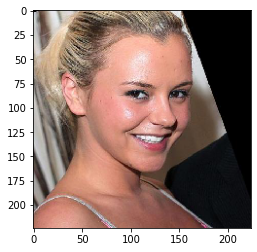

real_age:  23


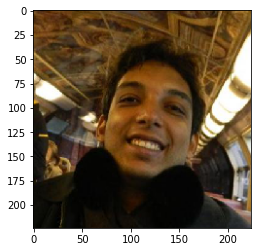

real_age:  32


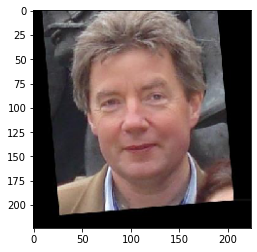

real_age:  49


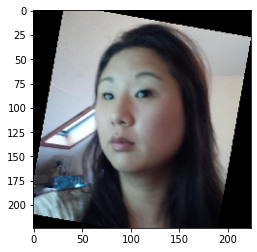

real_age:  32


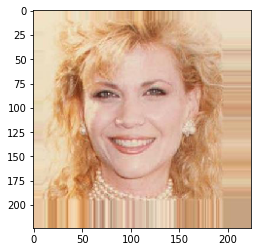

real_age:  38


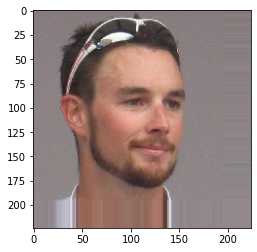

real_age:  25


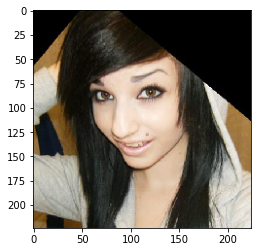

real_age:  16


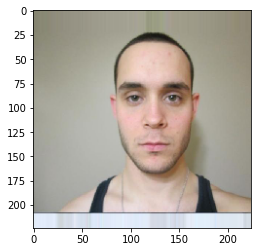

real_age:  23


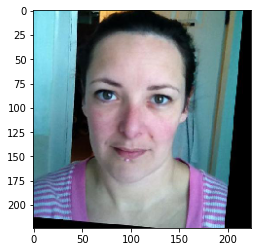

real_age:  34


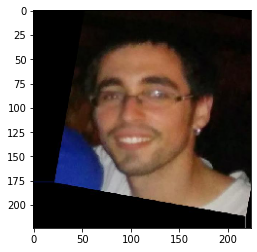

real_age:  24


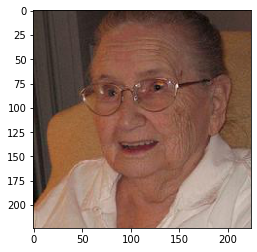

real_age:  90


In [13]:
for i in range(0,11):
    plt.figure()
    plt.imshow(features[i])
    plt.show()
    print('real_age: ', target[i])

Из дополнительных выборочных 10 фотографий видно:
- как и показала характеристика выборки, *диапазон возрастов довольно широкий*, 
- часто человек выглядит не соотвествующим своему возрасту (*моложе или наоборот старше*), 
- также в наборе данных фоторафии *разных национальностей*, что несомненно усложняет задачу.

### Вывод

- В исходном наборе данных **7591 фотография** с соответствующей меткой о реальном возрасте человека.
- *Максимум* выборки возрастов - 100 лет, *минимум* - 1 год.
- Среднее значение **31,2**, медиана **29**. Стандартное отклонение больше половины среднего значения. Что говорит о наличии скошенности датафрейма. 
- Из гистограммы количества фотографий по возрастам мы видим, что **датафрейм имеет два пика**:
    - первый в детском возрасте,
    - второй в возрасте около 25-30 лет.
- Визуально можно отнести датафрейм к **скошенным вправо**, так как после пика 25-30 лет начинается более плавное снижение количества фотографий до возраста 100 лет, чем в область детского возраста, где количество фотографий сначала резко снижается до возраста примерно около 10 лет, затем увеличивается до второго пика количества фотографий младенческого возраста.
- Вывод на экран 20 выборочных фотографий показывает, что **поставленная задача непростая** *даже для человека*, так как в наборе данных фотографии людей разной национальности, с посторонними (для модели) предметами (очки, жвачка, микрофон и пр.).

Предварительно можно утверждать, что **данных для исследования достаточно**.

## Обучение модели

### Краткое описание разработанной модели

Для выполнения поставленной задачи воспользуемся архитектурой `ResNet`.  

Некоторые отличительные особенности `ResNet`:
- В `ResNet` у всех свёрток, кроме первой, фильтры размером не больше 3x3.
- Присутствую соединения между слоями, идущими не подряд. Такие соединения называются - `Skip-connections`. Они работают лучше, потому что помогают сигналу не затухать при прохождении через очень глубокую сеть. А чем глубже сеть, тем более сложную функцию она может выучить.
- `ResNet` использует `Bottleneck`-блок, который позволяет сократить количество весов. 

Популярные модификации этой архитектуры такие: `ResNet18`, `ResNet34`, `ResNet50`, `ResNet101` и `ResNet152`. Последние три уже есть в `Keras`. Число в названии означает, сколько в сети слоёв.

Воспользуемся для поставленной задачи архитектурой `ResNet50`.

Код был подготовлен и был направлен на сервер для обучения на графическом процессоре.

**Код, загружаемый на сервер, включает 4 функции**:
- `load_train(path)` - подготовка обучающей выборки,
- `load_test(path)` - подготовка валидационной выборки,
- `create_model(input_shape)` - создание модели с использованием `ResNet50`,
- `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)` - функция для обучения модели.

Функцией потерь для `model.compile()` выбрана $MSE$, так как зачастую нейронные сети с функцией потерь $MSE$ обучаются быстрее.

В качестве оптимизатора выбран алгоритм `Adam`.

В ходе расчетов сначала варьировалась **скорость обучения**, на последнем расчете также было увеличено **количество эпох**.

Результаты приводятся ниже после текста программы.

### Код модели нейронной сети

**Код, загруженный на сервер** для обучения на графическом процессоре (*Tesla V100-SXM2-32GB*), приведён ниже: 

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    
    labels = pd.read_csv(path +'labels.csv')
    
    train_datagen = ImageDataGenerator( validation_split=0.25,
                                        rescale=1./255)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=(path +'final_files/'),
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)
    return train_datagen_flow

def load_test(path):
    
    labels = pd.read_csv(path +'labels.csv')
    
    validation_datagen = ImageDataGenerator(validation_split=0.25,
                                            rescale=1./255)
    
    test_datagen_flow = validation_datagen.flow_from_dataframe(dataframe=labels,
                                                               directory=(path +'final_files/'),
                                                               x_col='file_name',
                                                               y_col='real_age',
                                                               target_size=(224, 224),
                                                               batch_size=32,
                                                               class_mode='raw',
                                                               subset='validation',
                                                               seed=12345) 

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=0.00025) #рассмотрены варианты 0.001,0.0005,0.00025
    model.compile(loss= 'mse', 
                  optimizer=optimizer, 
                  metrics=["mae"])
    return model


def train_model(model, 
                train_datagen_flow, 
                test_datagen_flow, 
                batch_size=None, 
                epochs=7,
                steps_per_epoch=None, 
                validation_steps=None):
        
    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
    
```

### Результаты для `lr=0.001`, `epochs=3`

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
(/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/3
2022-05-15 18:20:58.851434: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-15 18:20:59.354995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 107s - loss: 228.9158 - mae: 11.5000 - val_loss: 2445.3114 - val_mae: 46.7012
Epoch 2/3
178/178 - 38s - loss: 149.8534 - mae: 9.3606 - val_loss: 296.4000 - val_mae: 12.8264
Epoch 3/3
178/178 - 38s - loss: 122.4126 - mae: 8.4688 - val_loss: 317.3745 - val_mae: 13.1775
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 317.3745 - mae: 13.1775
Test MAE: 13.1775
```

**Разультат** неудовлитворительный. 

Уменьшим скорость обучения до `0.0005`, пока что сохраним количество эпох.

### Результаты для `lr=0.0005`, `epochs=3`

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
(/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/3
2022-05-15 18:32:15.675535: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-15 18:32:15.967089: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 196.2207 - mae: 10.3355 - val_loss: 384.1759 - val_mae: 14.6429
Epoch 2/3
178/178 - 38s - loss: 98.4417 - mae: 7.5160 - val_loss: 357.0113 - val_mae: 14.0631
Epoch 3/3
178/178 - 38s - loss: 64.3694 - mae: 6.1514 - val_loss: 294.6435 - val_mae: 12.8659
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 294.6435 - mae: 12.8659
Test MAE: 12.8659

```

**Результат улучшился**, но не дотягивает до целевого значения. 

Ещё раз *уменьшим скорость обучения* до `0.0025` и увеличим *количество эпох до* `7`. Так как по двум предыдущим расчетам видно, что, вероятно, 3 эпох может быть недостаточно.

### Результаты для `lr=0.00025`, `epochs=7`

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
(/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/7
2022-05-15 19:04:57.182381: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-15 19:04:57.469201: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 45s - loss: 191.5041 - mae: 10.1416 - val_loss: 733.7568 - val_mae: 22.1478
Epoch 2/7
178/178 - 37s - loss: 76.8708 - mae: 6.6963 - val_loss: 484.6786 - val_mae: 16.8335
Epoch 3/7
178/178 - 38s - loss: 41.9385 - mae: 4.9362 - val_loss: 439.2212 - val_mae: 15.7483
Epoch 4/7
178/178 - 38s - loss: 26.9314 - mae: 4.0225 - val_loss: 119.2467 - val_mae: 8.1774
Epoch 5/7
178/178 - 38s - loss: 19.6032 - mae: 3.4044 - val_loss: 87.0872 - val_mae: 6.9511
Epoch 6/7
178/178 - 38s - loss: 15.0242 - mae: 2.9877 - val_loss: 77.1663 - val_mae: 6.5821
Epoch 7/7
178/178 - 38s - loss: 11.7477 - mae: 2.6334 - val_loss: 72.7385 - val_mae: 6.3375
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 72.7385 - mae: 6.3375
Test MAE: 6.3375

```

Целевой результат достигнут, итоговая метрика **MAE на тестовой выборке 6.3375**.

Целевой результат был достигнут уже на 5-ой эпохе, но с каждой эпохой он только улучшался.

### Вывод

- Построена модель нейронной сети на основе архитектуры `ResNet50`, доступной в библиотеки `Keras`. 
- Функция потерь для `model.compile()` - `MSE`, целевая метрика - `MAE`.
- Уровень целевой метрики, ниже которого нужно опуститься: **`MAE<8`**.
- В качестве оптимизатора выбран алгоритм `Adam`, в качестве функции активизации `relu`.
- Обучение выполнено путём загрузки расчетного файла на сервер для вычислений на графическом процессоре *Tesla V100-SXM2-32GB*
- В ходе обучения варьировалась скорость обучения `lr`, рассмотрены три варианта `0.001`, `0.0005`, `0.00025`
- Количество эпох для первых двух значений `lr` составляло `3` и целевая метрика не была достигнута
- Для `lr=0.00025` количество эпох увеличено до `7` и целевая метрика достигнута: **MAE на тестовой выборке 6.3375**.

## Анализ обученной модели

Проведём анализ результатов обучения модели.

Так как мы, по факту, рассмотрели три варианта параметров модели разработанной нейронной сети, то соберём результаты в общую таблицу:

In [14]:
results = pd.DataFrame({'variant_number':['variant_1',
                                          'variant_2',
                                          'variant_3'],
                        'architecture':['ResNet50',
                                        'ResNet50',
                                        'ResNet50'],
                        'optimizer':['Adam',
                                     'Adam',
                                     'Adam'],
                        'activation':['relu','relu','relu'],
                        'lr':[0.001,0.0005,0.00025],
                        'epochs':[3,3,7],
                         'MAE_test':[13.1775, 12.8659,6.3375]})

In [15]:
results

,variant_number,architecture,optimizer,activation,lr,epochs,MAE_test
0,variant_1,ResNet50,Adam,relu,0.00100,3,13.1775
1,variant_2,ResNet50,Adam,relu,0.00050,3,12.8659
2,variant_3,ResNet50,Adam,relu,0.00025,7,6.3375


In [16]:
fit_progress = pd.DataFrame({'epoch_number':[1,2,3,4,5,6,7],
                             'val_mae_1':[46.7012,
                                          12.8264,
                                          13.1775,
                                          None,
                                          None,
                                          None,
                                          None],
                             'val_mae_2':[14.6429,
                                          14.0631,
                                          12.8659,
                                          None,
                                          None,
                                          None,
                                          None],
                             'val_mae_3':[22.1478, 
                                          16.8335, 
                                          15.7483,
                                          8.1774,
                                          6.9511,
                                          6.5821,
                                          6.3375]})

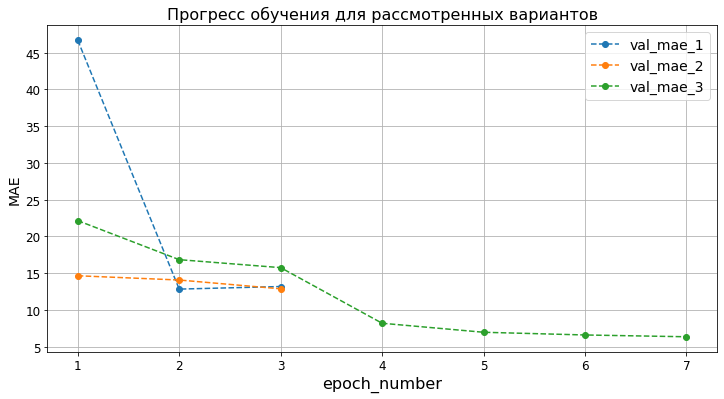

In [17]:
#размер графика
plt.figure(figsize=(12,6))

for name in ['val_mae_1','val_mae_2','val_mae_3']:
    #строим график
    plt.plot(fit_progress['epoch_number'],
             fit_progress[name],
             '--o',
             label=name
            )

#название графика
plt.title('Прогресс обучения для рассмотренных вариантов', fontsize=16)

#подписи осей
plt.xlabel('epoch_number', fontsize=16)
plt.ylabel('MAE', fontsize=14)

#отображение сетки
plt.grid()

#задаём шаг сетки по оси по оси абсцисс и по оси ординат
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=14)
plt.show()

### Вывод

Снижение скорости обучения для алгоритма `Adam` и увеличение количества эпох позволили снизить целевую **метрику MAE ниже 7**. 

Анализ прогресса обучения показывает, что *уменьшение скорости обучения* в первом случае привело к снижению `MAE` уже на первой эпохе (val_mae_2), но дальнейшее снижение скорости (до 0.00025) привело к увеличению `MAE` на первой эпохе, однако после 3-ей эпохи результаты начали улучшаться и достигли целевого уровня.

## Общий вывод

Задача проекта состояла в разработке модели, которая **по фотографии определит приблизительный возраст** человека. 

В нашем распоряжении был набор фотографий людей с указанием возраста.

**1. В ходе исследовательского анализа исходных данных выявлено:**

- В исходном наборе данных **7591 фотография** с соответствующей меткой о реальном возрасте человека.
- *Максимум* выборки возрастов - 100 лет, *минимум* - 1 год.
- Среднее значение **31,2**, медиана **29**. Стандартное отклонение больше половины среднего значения. Что говорит о наличии скошенности датафрейма. 
- Из гистограммы количества фотографий по возрастам мы видим, что **датафрейм имеет два пика**:
    - первый в детском возрасте,
    - второй в возрасте около 25-30 лет.
- Визуально можно отнести датафрейм к **скошенным вправо**, так как после пика 25-30 лет начинается более плавное снижение количества фотографий до возраста 100 лет, чем в область детского возраста, где количество фотографий сначала резко снижается до возраста примерно около 10 лет, затем увеличивается до второго пика количества фотографий младенческого возраста.
- Вывод на экран 20 выборочных фотографий показывает, что **поставленная задача непростая** *даже для человека*, так как в наборе данных фотографии людей разной национальности, с посторонними (для модели) предметами (очки, жвачка, микрофон и пр.).

**2. Реузльтаты стадии обучения модели:**
- Построена модель нейронной сети на основе архитектуры `ResNet50`, доступной в библиотеки `Keras`. 
- Функция потерь для `model.compile()` - `MSE`, целевая метрика - `MAE`.
- Уровень целевой метрики, ниже которого нужно опуститься: **`MAE<8`**.
- В качестве оптимизатора выбран алгоритм `Adam`, в качестве функции активизации `relu`.
- Обучение выполнено путём загрузки расчетного файла на сервер для вычислений на графическом процессоре *Tesla V100-SXM2-32GB*
- В ходе обучения варьировалась скорость обучения `lr`, рассмотрены три варианта `0.001`, `0.0005`, `0.00025`
- Количество эпох для первых двух значений `lr` составляло `3` и целевая метрика не была достигнута
- Для `lr=0.00025` количество эпох увеличено до `7` и целевая метрика достигнута: **MAE на тестовой выборке 6.3375**.

**3. Анализ прогресса обучения позволяет сделать вывод:**
- Снижение скорости обучения для алгоритма `Adam` и увеличение количества эпох позволили снизить целевую **метрику MAE ниже 7**. 
- *Уменьшение скорости обучения* в первом случае привело к снижению `MAE` уже на первой эпохе, но дальнейшее снижение скорости привело к увеличению `MAE` на первой эпохе, однако после 3-ей эпохи результаты начали улучшаться и достигли целевого уровня.

Поставленная задача выпонлена в полном объёме, разработана модель, способная распознавать возраст по фотографии с требуемым уровнем целевой метрики (`MAE<8`). 

Выводы о том удовлетворяет ли данная модель потребности бизнеса предстоит сделать после первичного тестирования. Возможно, для определения совершеннолетия точности может быть недостаточно.